In [1]:
import numpy as np
import os
from os import listdir
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix

In [3]:
#Load the dataset
import pandas as pd

#The data set : https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge?resource=download
#take the file "icml_face_data.csv" and put it in the same folder as this main.ipynb

# read the CSV file
df = pd.read_csv("icml_face_data.csv")

num_classes = 7

# print the first few rows of the DataFrame
print(df.head())

   emotion     Usage                                             pixels
0        0  Training  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  Training  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  Training  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  Training  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  Training  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [4]:
def remove_emotion(df, numberEmotion):
    '''Remove the "numberEmotion" from the dataset df'''
    maskEmotion = df["emotion"] != numberEmotion

    return df.loc[maskEmotion]

# If we want to remove an emotion from the data, we can use this code
# df = remove_emotion(df, 2)
# df = remove_emotion(df, 3)
# df = remove_emotion(df, 6)
df = df.reset_index()
df

,index,emotion,Usage,pixels
0,0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...,...
35882,35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
35885,35885,3,PrivateTest,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [5]:
#Split between training and test
maskTraining = df[" Usage"] == "Training"
maskTest = [not elem for elem in maskTraining]

df_train = df.loc[maskTraining]
df_test = df.loc[maskTest]

In [6]:
def list_string_to_arrayImages(L, sizeX=48, sizeY=48):

    Images_Dataset = []
    for k in range(L.index[0], L.index[-1] + 1):
        # split the string into a list of strings
        # lst = df[" pixels"][k].split()
        lst = L[k].split()

        # convert the strings to integers using map() and a lambda function
        lst = list(map(lambda x: int(x), lst))

        Images_Dataset.append(lst)
    Images_Dataset = np.array(Images_Dataset)
    Images_Dataset = Images_Dataset.reshape(Images_Dataset.shape[0], sizeX , sizeY)
    Images_Dataset = Images_Dataset.astype('float32')
    Images_Dataset /= 255
    return Images_Dataset

In [7]:
#Proprocess dataset and get X_train and X_test
X_train = list_string_to_arrayImages(df_train[" pixels"])
X_test = list_string_to_arrayImages(df_test[" pixels"])

print((X_train).shape)
print((X_test).shape)


(28709, 48, 48)
(7178, 48, 48)


In [8]:
#get y_train and y_test
Labels_train = list(df_train["emotion"])
Labels_test = list(df_test["emotion"])

In [9]:
#change the shape of the object labels
y_train = to_categorical(Labels_train, num_classes) 
y_test = to_categorical(Labels_test, num_classes) 

In [10]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Epoch 1/20
898/898 [==============================] - 37s 39ms/step - loss: 1.6139 - accuracy: 0.3761
Epoch 2/20
898/898 [==============================] - 33s 37ms/step - loss: 1.4478 - accuracy: 0.4519
Epoch 3/20
898/898 [==============================] - 32s 36ms/step - loss: 1.3649 - accuracy: 0.4880
Epoch 4/20
898/898 [==============================] - 32s 35ms/step - loss: 1.2996 - accuracy: 0.5196
Epoch 5/20
898/898 [==============================] - 30s 33ms/step - loss: 1.2444 - accuracy: 0.5367
Epoch 6/20
898/898 [==============================] - 35s 39ms/step - loss: 1.1949 - accuracy: 0.5574
Epoch 7/20
898/898 [==============================] - 35s 39ms/step - loss: 1.1499 - accuracy: 0.5776
Epoch 8/20
898/898 [==============================] - 31s 35ms/step - loss: 1.1049 - accuracy: 0.5950
Epoch 9/20
898/898 [==============================] - 27s 30ms/step - loss: 1.0680 - accuracy: 0.6060
Epoch 10/20
898/898 [==============================] - 40s 45ms/step - loss: 1.030

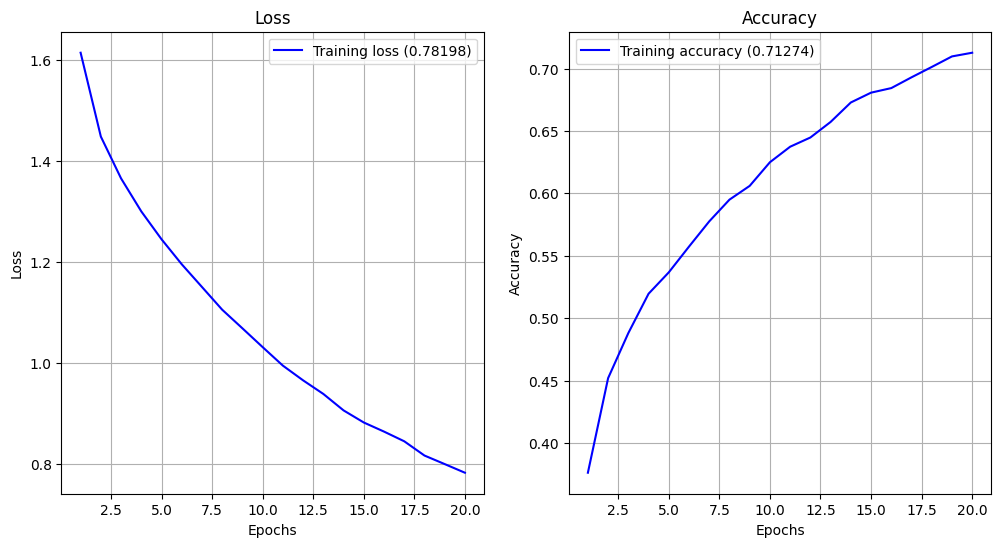

225/225 [==============================] - 2s 7ms/step
Accuracy: 0.4913624965171357
898/898 [==============================] - 6s 7ms/step


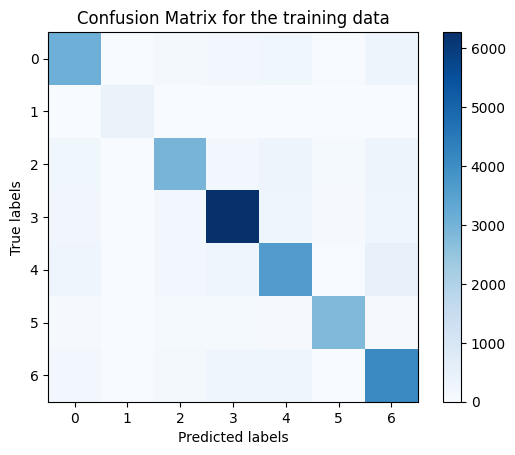

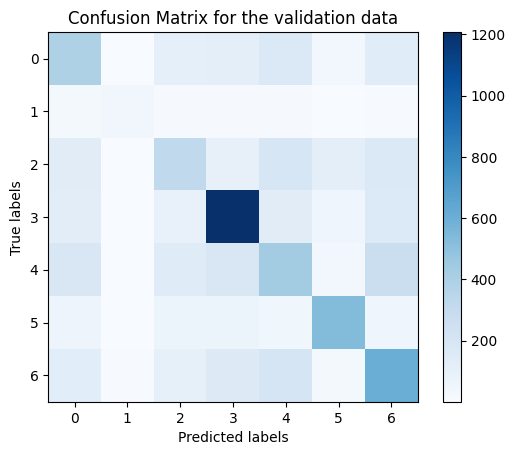

Accuracy by class: [0.40605427974947805, 0.36936936936936937, 0.310546875, 0.6803833145434047, 0.3480352846832398, 0.6389891696750902, 0.49229521492295214]
Precision: [0.37153773 0.73214286 0.37411765 0.65848336 0.36378877 0.67045455
 0.43141436]
Recall: [0.40605428 0.36936937 0.31054688 0.68038331 0.34803528 0.63898917
 0.49229521]
F1 score: [0.38802993 0.49101796 0.339381   0.66925423 0.3557377  0.65434381
 0.45984848]


In [15]:
# This is the first proposed model. It simply starts by including an initial convolutional layer of shape 32 and a pooling 2x2 layer, 
# followed by a flatten layer. The initial convolutional layer uses the activation function ReLu, as it has been observed that it is the one that
# gets the best results (the accuracies for the sigmoid function, for example, are well below the results obtained with ReLu); 
# the final/output layer uses the Softmax activation function, as it is normally done. The resulting training accuracy is 
# aproximately 61% with 10 epochs, and a validation accuracy of 48%. This result is not acceptable, so the number of epochs was increased to 
# 20 to try and get better results, but although the training accuracy increased, the validation accuracy decreased slightly. 
# It was also tried with 15 epochs but the results were not better either, reaching an accuracy of  47,8%. This is probably due to overfitting in 
# the training of the model, something that can be avoided including a dropout layer with frequency rate 0.25.
# When this layer is added, the validation accuracy is increased to a 48,1% with 15 epoch and 48,6% with 20 epoch. If the dropout layer's frequency
# is increased to 0.5, the result is a validation accuracy of 47,7% with 15 epoch and 47,9% with 20 epoch. Therefore, the final dropout frequency has been
# stablished to 0.25, and the epochs to use will be 20. The initial convolutional layer has been increased to a shape of 64 and, although the training time
# slightly increases, the validation accuracy gets to almost 50%. It is expected that, if the depth level (shape) of this layer is increased, the training will
# be more effective, but the training time much longer everytime, so it has been decided to only increase it until 64. In the following models, layers of larger depths
# are regarded, and can be observed how the results are much better. In conclusion, if this was the model to use, the best option would be to add a dropout layer with a frequency of 0.25, train 
# the model in 20 epochs, and change the convolutional layer to 64 of depth.
# define the model number 1
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32) # the epochs MUST be incremented, the results are way better

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Epoch 1/15
898/898 [==============================] - 71s 79ms/step - loss: 1.5361 - accuracy: 0.4082
Epoch 2/15
898/898 [==============================] - 68s 76ms/step - loss: 1.3157 - accuracy: 0.4998
Epoch 3/15
898/898 [==============================] - 65s 72ms/step - loss: 1.1932 - accuracy: 0.5497
Epoch 4/15
898/898 [==============================] - 63s 70ms/step - loss: 1.0829 - accuracy: 0.5954
Epoch 5/15
898/898 [==============================] - 66s 74ms/step - loss: 0.9694 - accuracy: 0.6415
Epoch 6/15
898/898 [==============================] - 64s 72ms/step - loss: 0.8417 - accuracy: 0.6903
Epoch 7/15
898/898 [==============================] - 64s 71ms/step - loss: 0.7339 - accuracy: 0.7303
Epoch 8/15
898/898 [==============================] - 63s 70ms/step - loss: 0.6179 - accuracy: 0.7740
Epoch 9/15
898/898 [==============================] - 62s 69ms/step - loss: 0.5278 - accuracy: 0.8110
Epoch 10/15
898/898 [==============================] - 65s 72ms/step - loss: 0.442

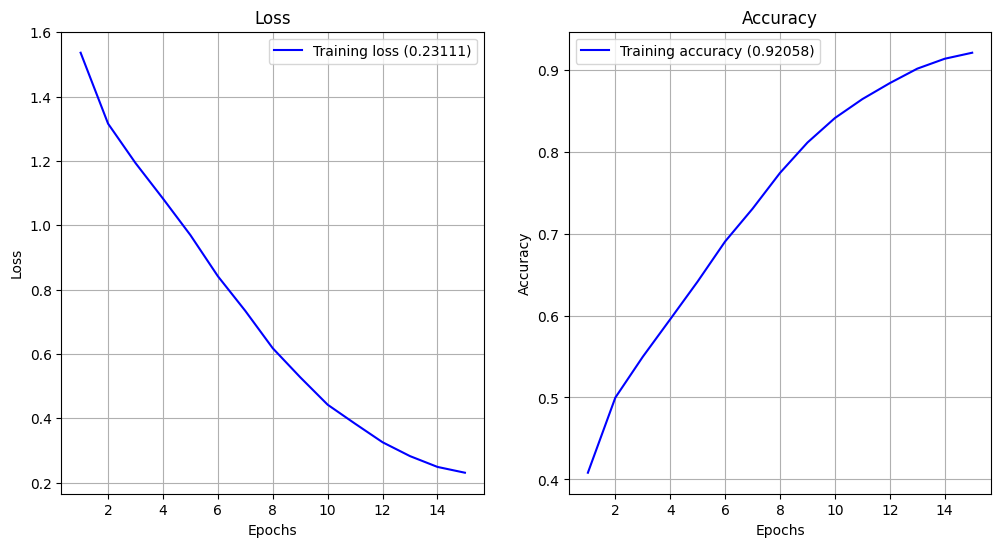

225/225 [==============================] - 4s 16ms/step
Accuracy: 0.5383115073836723
898/898 [==============================] - 15s 16ms/step


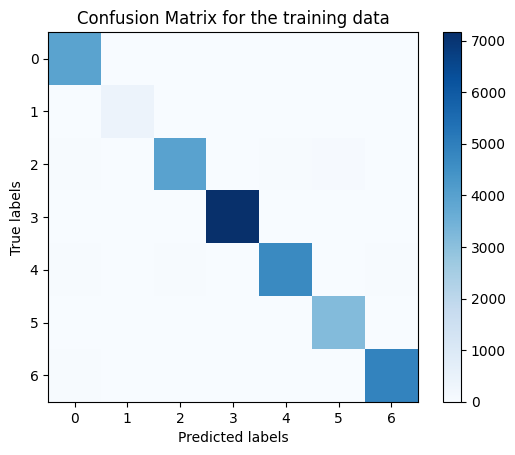

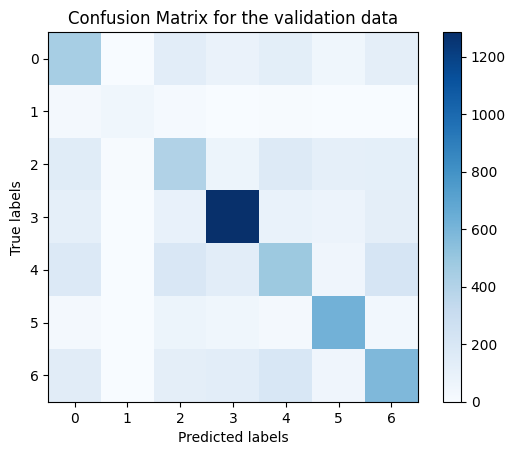

Accuracy by class: [0.46346555323590816, 0.42342342342342343, 0.3955078125, 0.7243517474633596, 0.3865276663993585, 0.7472924187725631, 0.47039740470397406]
Precision: [0.41263941 0.81034483 0.39130435 0.7292849  0.44220183 0.64822547
 0.48373645]
Recall: [0.46346555 0.42342342 0.39550781 0.72435175 0.38652767 0.74729242
 0.4703974 ]
F1 score: [0.43657817 0.55621302 0.39339485 0.72680995 0.41249465 0.69424259
 0.47697368]


In [16]:
# The second model adds a second convolutional layer of shape 64 and, after the flattening of the data, a normal layer of shape 128.
# The increase in the number of layers (convolutional and normal layers) really affects the training time, taking almost 4 minutes to train
# an iteration. Also the increase in the depth of the second convolutional layer contributes to this. The training accuracy is almost 98%, 
# something much better than the previous model. Nevertheless, the validation accuracy only slightly reaches 50%, what show that the model is overfitted.
# To solve this, a dropout layer with a frequency of 0.25 is added after the pooling layer. The result is a slightly worse result in the training accuracy 
# (90% in this case), but the validation accuracy increases to almost 51%. If the number of epochs is increased to 15, the validation accuracy gets to almost 53%,
# but of course, the training time increases greatly. It has also been tried to increase the pool size of the convolutional layer to 3x3 initially, and although 
# the results were a better validation accuracy, the diference was minimum (1%).
# define the model number 2
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Epoch 1/10
898/898 [==============================] - 36s 40ms/step - loss: 1.6900 - accuracy: 0.3266
Epoch 2/10
898/898 [==============================] - 34s 38ms/step - loss: 1.5815 - accuracy: 0.3816
Epoch 3/10
898/898 [==============================] - 35s 39ms/step - loss: 1.5252 - accuracy: 0.4071
Epoch 4/10
898/898 [==============================] - 34s 38ms/step - loss: 1.4746 - accuracy: 0.4281
Epoch 5/10
898/898 [==============================] - 35s 39ms/step - loss: 1.4233 - accuracy: 0.4488
Epoch 6/10
898/898 [==============================] - 34s 38ms/step - loss: 1.3699 - accuracy: 0.4740
Epoch 7/10
898/898 [==============================] - 35s 39ms/step - loss: 1.3206 - accuracy: 0.4965
Epoch 8/10
898/898 [==============================] - 36s 41ms/step - loss: 1.2607 - accuracy: 0.5199
Epoch 9/10
898/898 [==============================] - 35s 39ms/step - loss: 1.2071 - accuracy: 0.5433
Epoch 10/10
898/898 [==============================] - 34s 38ms/step - loss: 1.145

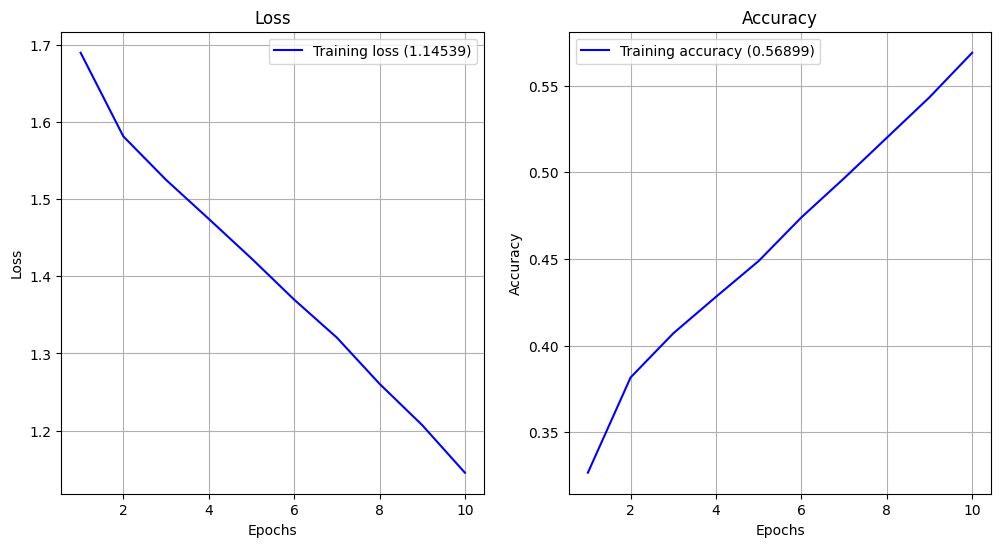

225/225 [==============================] - 3s 15ms/step
Accuracy: 0.416829200334355
898/898 [==============================] - 14s 16ms/step


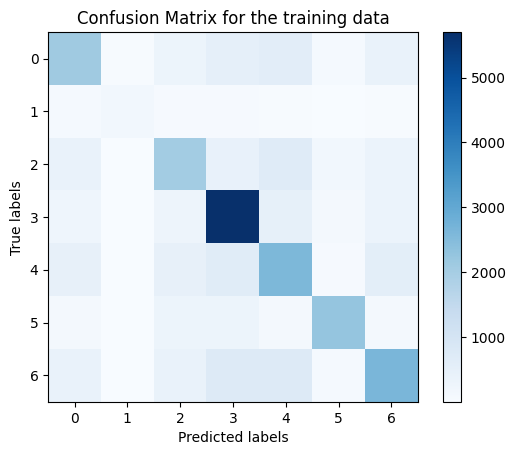

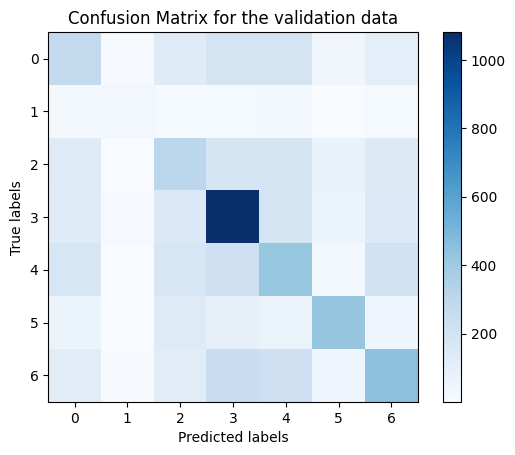

Accuracy by class: [0.29227557411273486, 0.24324324324324326, 0.294921875, 0.6093573844419391, 0.3392141138732959, 0.5174488567990373, 0.36415247364152475]
Precision: [0.30434783 0.40298507 0.29406037 0.52938296 0.31972789 0.62773723
 0.40305206]
Recall: [0.29227557 0.24324324 0.29492188 0.60935738 0.33921411 0.51744886
 0.36415247]
F1 score: [0.29818956 0.30337079 0.29449049 0.56656184 0.32918288 0.56728232
 0.38261611]


In [25]:
# define the model number 3
# This model is the simplest in terms of conceptualization, as it is a basic neural network consisting solely of dense layers (fully connected layers).
# Although it has a satisfactory training accuracy after 10 epochs, this model performs poorly in terms of generalization, as evidenced by its low validation accuracy of 0.41

model = Sequential()
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Dense(20, activation='relu', input_shape=(48, 48, 1)))
model.add(Flatten())
model.add(Dense(100, activation='relu', input_shape=(48, 48, 1)))
model.add(Dense(100, activation='relu', input_shape=(48, 48, 1)))
model.add(Dense(num_classes, activation='sigmoid', ))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

Epoch 1/10
898/898 [==============================] - 114s 127ms/step - loss: 1.7085 - accuracy: 0.3098
Epoch 2/10
898/898 [==============================] - 113s 125ms/step - loss: 1.4221 - accuracy: 0.4506
Epoch 3/10
898/898 [==============================] - 113s 126ms/step - loss: 1.2762 - accuracy: 0.5107
Epoch 4/10
898/898 [==============================] - 115s 128ms/step - loss: 1.2008 - accuracy: 0.5428
Epoch 5/10
898/898 [==============================] - 113s 125ms/step - loss: 1.1455 - accuracy: 0.5639
Epoch 6/10
898/898 [==============================] - 118s 132ms/step - loss: 1.0860 - accuracy: 0.5888
Epoch 7/10
898/898 [==============================] - 132s 147ms/step - loss: 1.0471 - accuracy: 0.6051
Epoch 8/10
898/898 [==============================] - 134s 149ms/step - loss: 1.0023 - accuracy: 0.6202
Epoch 9/10
898/898 [==============================] - 172s 191ms/step - loss: 0.9646 - accuracy: 0.6350
Epoch 10/10
898/898 [==============================] - 159s 177m

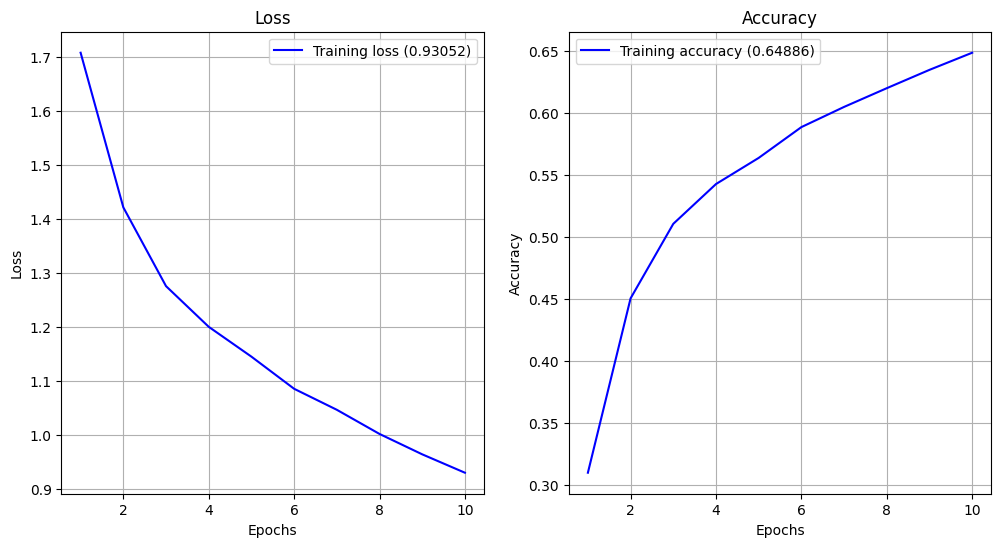

225/225 [==============================] - 7s 32ms/step
Accuracy: 0.5860964056840345
898/898 [==============================] - 29s 32ms/step


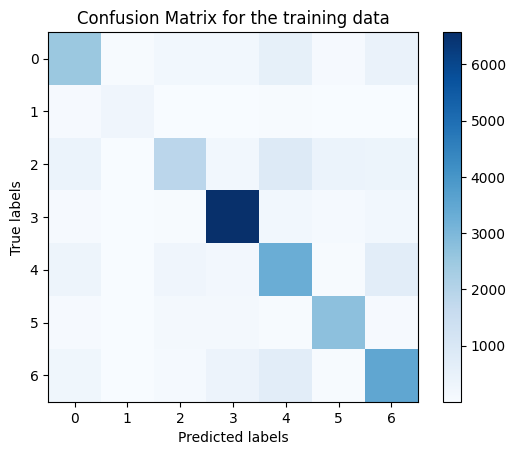

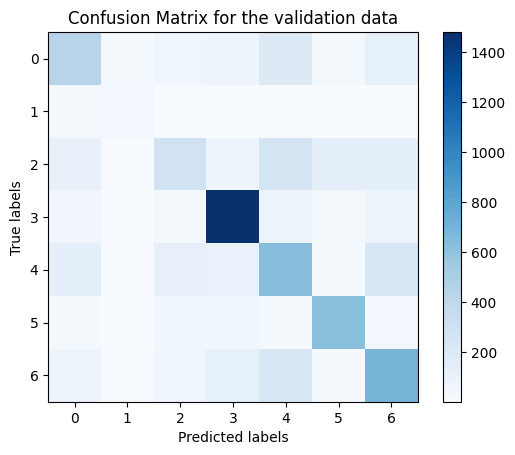

Accuracy by class: [0.4603340292275574, 0.38738738738738737, 0.27734375, 0.8348365276211951, 0.5068163592622293, 0.7545126353790613, 0.5669099756690997]
Precision: [0.49718151 0.44791667 0.4522293  0.77055151 0.4394993  0.71821306
 0.52398801]
Recall: [0.46033403 0.38738739 0.27734375 0.83483653 0.50681636 0.75451264
 0.56690998]
F1 score: [0.47804878 0.41545894 0.34382567 0.80140693 0.4707635  0.73591549
 0.5446046 ]


In [14]:
## define the model number 4
# This model is the most complicated, 4 Conv layers, 3 MaxPooling layers, 2 Dense layers. dropout layers are for reducing overfitting risk.
# This is the better result we have so far. Even if the accuracy during the training was lower than the one for model number3, the validation is way better. 
# This model is better for extracting informations and actually learning.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32)

# check model results
plot_history(history)

# predictions  with the test data
predictions = model.predict(X_test)

# calculate the accuracy of the predictions
accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
print('Accuracy:', accuracy)

predictions_class_train = np.argmax(model.predict(X_train), axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_train, axis=1), predictions_class_train)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the training data')
plt.show()

predictions_class = np.argmax(predictions, axis=1)
# y_test and predictions_class are the true labels and predicted labels, respectively
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions_class)
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for the validation data')
plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

accuracies = []
for i in range(num_classes):
    accuracy = cm[i, i] / cm[i].sum()
    accuracies.append(accuracy)
print("Accuracy by class:", accuracies)

# calculate the precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
recall = recall_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)
f1 = f1_score(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), average=None)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

In [20]:
#function to print the accuracy for the validation during the process and not only at the end.
def compute_differentEpochs(model, epochFin, epochPas = 2, epochStart=0, X_train = X_train, y_train=y_train, X_test = X_test, y_test=y_test, verbose=0):
    currentEpoch = epochStart + epochPas
    if(currentEpoch > epochFin):
        return
    else :
        history = model.fit(X_train, y_train, epochs=epochPas, batch_size=32, verbose=verbose)

        # Print the accuracy for the training with 
        acc = history.history['accuracy']
        print("Training accuracy for epoch = " + str(currentEpoch) + ": " + str(acc[-1]))

        # predictions  with the test data
        predictions = model.predict(X_test)

        # calculate the accuracy of the predictions
        accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1))
        print("Validation accuracy for epoch = " + str(currentEpoch) + ": " + str(accuracy))
        compute_differentEpochs(model, epochFin, epochPas = epochPas, epochStart=currentEpoch, X_train = X_train, y_train=y_train, X_test = X_test, y_test=y_test, verbose=verbose)
        return 

In [ ]:
# print the validation accuracy for the model 4 on different steps.
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#print different accuracy
compute_differentEpochs(model, 12, verbose=1)